In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Experimental data

Data shapes
Sqh:  (50, 2, 2, 236, 200)
Cad:  (50, 236, 200)
Vel:  (50, 2, 236, 200)


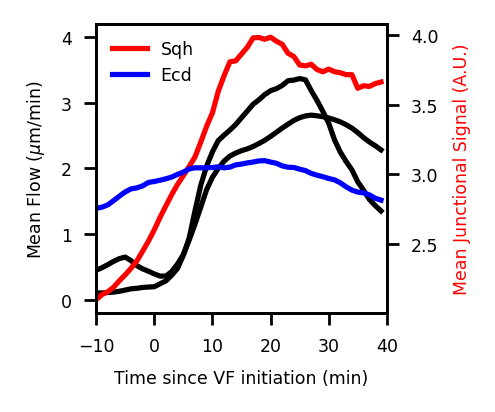

In [2]:
plt.rcParams['font.size'] = 5

loaddir = 'Public/WT/ECad-GFP/ensemble/'
cad = np.load(os.path.join(loaddir, 'cyt2D.npy'), mmap_mode='r')
cad_vel = np.load(os.path.join(loaddir, 'velocity2D.npy'), mmap_mode='r')

loaddir = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble/'
sqh = np.load(os.path.join(loaddir, 'tensor2D.npy'), mmap_mode='r')
vel = np.load(os.path.join(loaddir, 'velocity2D.npy'), mmap_mode='r')
t = np.load(os.path.join(loaddir, 't.npy'), mmap_mode='r')
DV = np.load(os.path.join(loaddir, 'DV_coordinates.npy'), mmap_mode='r')
AP = np.load(os.path.join(loaddir, 'AP_coordinates.npy'), mmap_mode='r')

dv = DV[:, 0]
ap = AP[0, :]

nDV = dv.shape[0]
nAP = ap.shape[0]
nTP = t.shape[0]
    
sqh = sqh * 3e1
cad = cad * 1.5e0
    
fig, ax = plt.subplots(1, 1, dpi=250, figsize=(1.5, 1.5))
ax2 = ax.twinx()
ax.plot(t, np.linalg.norm(vel, axis=1).mean(axis=(1, 2)), 
        color='black', label='Vel')
ax.plot(t, np.linalg.norm(cad_vel, axis=1).mean(axis=(1, 2)), 
        color='black', label='Vel')
ax2.plot(t, np.linalg.norm(sqh, axis=(1, 2)).mean(axis=(1, 2)), 
         color='red', label='Sqh')
ax2.plot(t, cad.mean(axis=(1, 2)), 
         color='blue', label='Ecd')
ax2.legend(framealpha=0)

ax.set_ylim([-0.2, 4.2])
ax.set_xlim([-10, 40])
ax.set_yticks([0, 1, 2, 3, 4])

ax.set_ylabel('Mean Flow ($\\mu$m/min)')
ax2.set_ylabel('Mean Junctional Signal (A.U.)', color='red')
ax.set_xlabel('Time since VF initiation (min)')

from scipy.ndimage import gaussian_filter
cad = np.stack([
    gaussian_filter(cad[i], sigma=4) for i in range(cad.shape[0])])
print('Data shapes')
print('Sqh: ', sqh.shape)
print('Cad: ', cad.shape)
print('Vel: ', vel.shape)

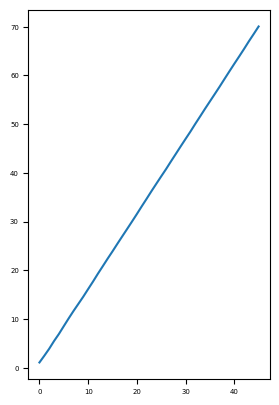

In [12]:
def radial_average(arr, num_bins=100):
    arr = arr.reshape([nDV, nAP])
    center = (nDV // 2, nAP // 2)

    x, y = np.meshgrid(np.arange(nAP), np.arange(nDV), indexing='xy')
    distances = np.hypot(x - center[1], y - center[0])

    sorted_distances = np.sort(distances.ravel())
    sorted_values = arr.ravel()[np.argsort(distances.ravel())]

    bins = np.linspace(0, (nAP/(2 * np.sqrt(2))), num_bins + 1)
    bins = np.linspace(0, sorted_distances.max(), num_bins+1)
    bin_indices = np.digitize(sorted_distances, bins)

    radial_avg = np.bincount(bin_indices, weights=sorted_values) / np.bincount(bin_indices)
    
    trunc = bins < nAP / (2 * 1.414)
    return radial_avg[1:][trunc]

qAP = np.fft.fftshift(np.fft.fftfreq(nAP, d=ap[1]-ap[0])) * np.ptp(AP)
qDV = np.fft.fftshift(np.fft.fftfreq(nDV, d=dv[1]-dv[0])) * np.ptp(DV)
q = np.linalg.norm(np.meshgrid(qAP, qDV, indexing='xy'), axis=0)
q = radial_average(q)
ax = plt.figure().gca()
ax.plot(np.arange(len(q)), q)
ax.set_aspect('equal')

Text(0, 0.5, '$|m(\\mathbf{q})|$')

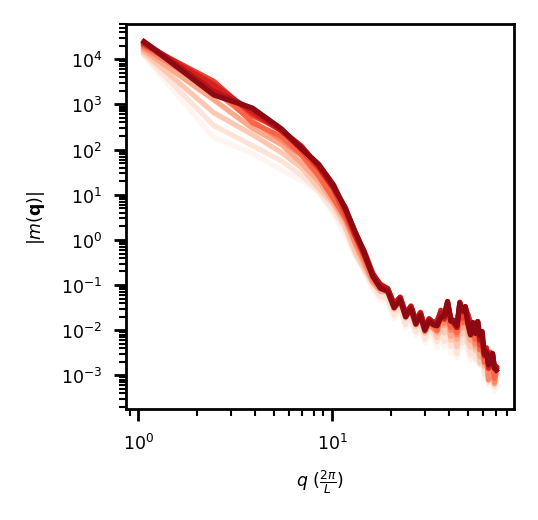

In [13]:
from scipy.signal import blackman, hann

window_AP = hann(nAP)
window_DV = hann(nDV)
window = window_AP[None, :] * window_DV[:, None]

sqh_q = np.sqrt(np.abs(np.fft.fft2(sqh * window))**2)
#sqh_q = np.sqrt(np.abs(np.fft.fft2(sqh))**2)

trm_q = np.einsum('tjjyx->tyx', sqh_q)
sqh_q = np.fft.ifftshift(sqh_q, axes=(-2, -1))
trm_q = np.fft.ifftshift(trm_q, axes=(-2, -1))
sqh_qt = np.apply_along_axis(radial_average, 1, trm_q.reshape([nTP, -1]))
cmap = plt.cm.Reds
norm = plt.Normalize(vmin=t.min(), vmax=t.max())
cmap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(1,1, figsize=(2, 2), dpi=250)
for tt in range(0, len(t), 5):
    ax.plot(q, sqh_qt[tt], c=cmap.to_rgba(t[tt]))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$q\ (\frac{2\pi}{L})$')
ax.set_ylabel(r'$|m(\mathbf{q})|$')

Text(0, 0.5, '$|c(\\mathbf{q})|$')

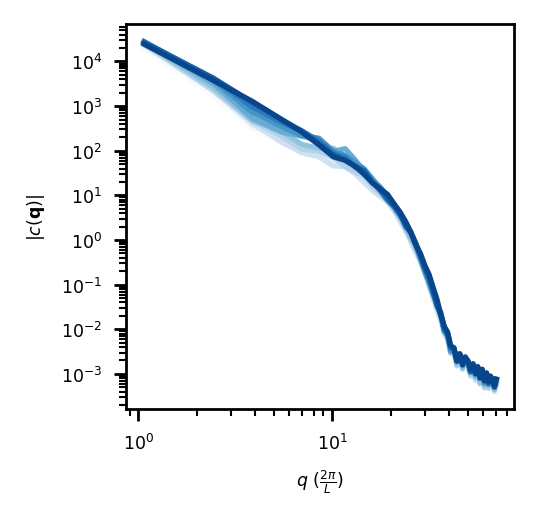

In [14]:
cad_q = np.sqrt(np.abs(np.fft.fft2(cad * window))**2)
#cad_q = np.sqrt(np.abs(np.fft.fft2(cad))**2)
cad_q = np.fft.ifftshift(cad_q, axes=(-2, -1))
cad_qt = np.apply_along_axis(radial_average, 1, cad_q.reshape([nTP, -1]))

cmap = plt.cm.Blues
norm = plt.Normalize(vmin=t.min(), vmax=t.max())
cmap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(1,1, figsize=(2, 2), dpi=250)
for tt in range(0, len(t), 5):
    ax.plot(q, cad_qt[tt], c=cmap.to_rgba(t[tt]))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$q\ (\frac{2\pi}{L})$')
ax.set_ylabel(r'$|c(\mathbf{q})|$')

Text(0, 0.5, '$|v(\\mathbf{q})|^2$')

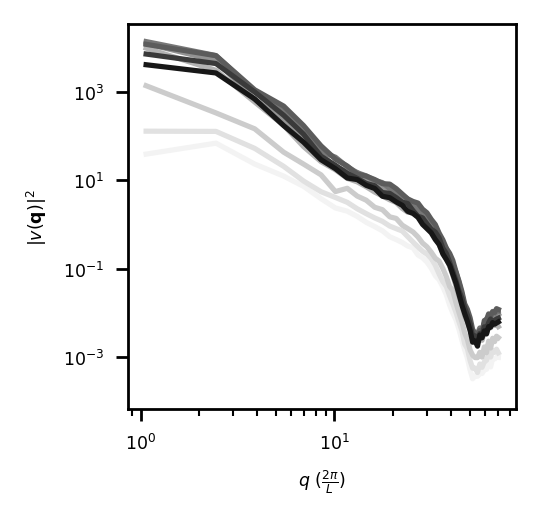

In [15]:
vel_q = np.sqrt(np.abs(np.fft.fft2(vel * window))**2)
#vel_q = np.sqrt(np.abs(np.fft.fft2(vel))**2)

vel_q = np.fft.ifftshift(vel_q, axes=(-2, -1))
vel_qt = np.apply_along_axis(radial_average, 1, vel_q[:, 0].reshape([nTP, -1]))

cmap = plt.cm.Greys
norm = plt.Normalize(vmin=t.min(), vmax=t.max())
cmap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(1,1, figsize=(2, 2), dpi=250)
for tt in range(0, len(t), 5):
    ax.plot(q, vel_qt[tt], c=cmap.to_rgba(t[tt]))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$q\ (\frac{2\pi}{L})$')
ax.set_ylabel(r'$|v(\mathbf{q})|^2$')

From the Stokes equation, we have
\begin{equation}
    v_i (\mathbf{q}) = -\frac{i \alpha}{\eta q^2} \left[\delta_{ij} - \frac{q_i q_j}{q^2} \right] q_k m_{jk} (\mathbf{q})
\end{equation}

Then if $m_{ij} (\mathbf{q}) \sim q^{-t}$, then $v_i(\mathbf{q}) \sim q^{-t-1}$

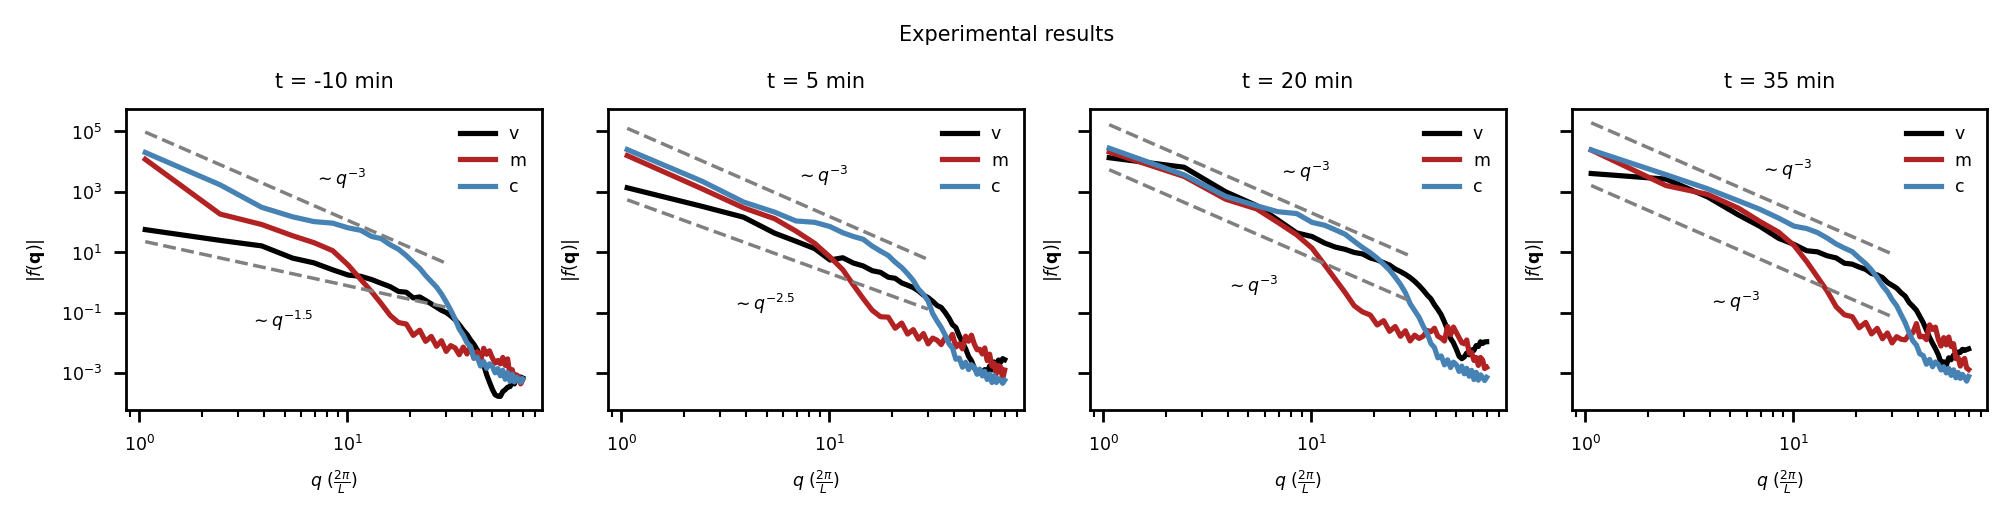

In [16]:
tt = [0, 15, 30, 45]
exps = -3
fig, ax = plt.subplots(1, len(tt), dpi=250, figsize=(2*len(tt), 2), sharex=True, sharey=True)
for i in range(len(tt)):
    ax[i].plot(q, vel_qt[tt[i]], color='black', label='v')
    ax[i].plot(q, sqh_qt[tt[i]], color='firebrick', label='m')
    ax[i].plot(q, cad_qt[tt[i]], color='steelblue', label='c')
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_xlabel(r'$q\ (\frac{2\pi}{L})$')
    ax[i].set_ylabel(r'$|f(\mathbf{q})|$')
    ax[i].legend(framealpha=0)
    ax[i].set_title(f't = {t[tt[i]]} min')
    
    exp = exps
    if t[tt[i]] < 0:
        exp2 = exp + 1.5
    elif t[tt[i]] < 10:
        exp2 = exp + 0.5
    else:
        exp2 = exp

    qs = q[:20]
    qe1 = np.power(qs, exp)
    
    qe2 = np.power(qs, exp2)

    qe1 = 8e0  * sqh_qt[tt[i], 0] * (qe1 / qe1[0])
    qe2 = 4e-1 * vel_qt[tt[i], 0] * (qe2 / qe2[0])
    ax[i].plot(qs, qe1, color='grey', linestyle='--', linewidth=1)
    ax[i].plot(qs, qe2, color='grey', linestyle='--', linewidth=1)
    ax[i].text(qs[4], qe1[4] * 3e0, r'$\sim q^{%g}$' % (exp),
                   va='bottom', ha='left')
    ax[i].text(qs[4], qe2[4] * 1e-1, r'$\sim q^{%g}$' % (exp2),
                   va='top', ha='right')    

fig.suptitle('Experimental results')

plt.tight_layout()

# Toy model

[[-1.  0. -1.]
 [ 0.  4.  0.]
 [-1.  0. -1.]]
[[[ 0.+32.5j  0. +0.j   0.+32.5j]
  [ 0. +0.j   0. +0.j   0. +0.j ]
  [ 0.-32.5j  0. +0.j   0.-32.5j]]

 [[-0.-32.5j  0. +0.j   0.+32.5j]
  [ 0. +0.j   0. +0.j   0. +0.j ]
  [-0.-32.5j  0. +0.j   0.+32.5j]]]


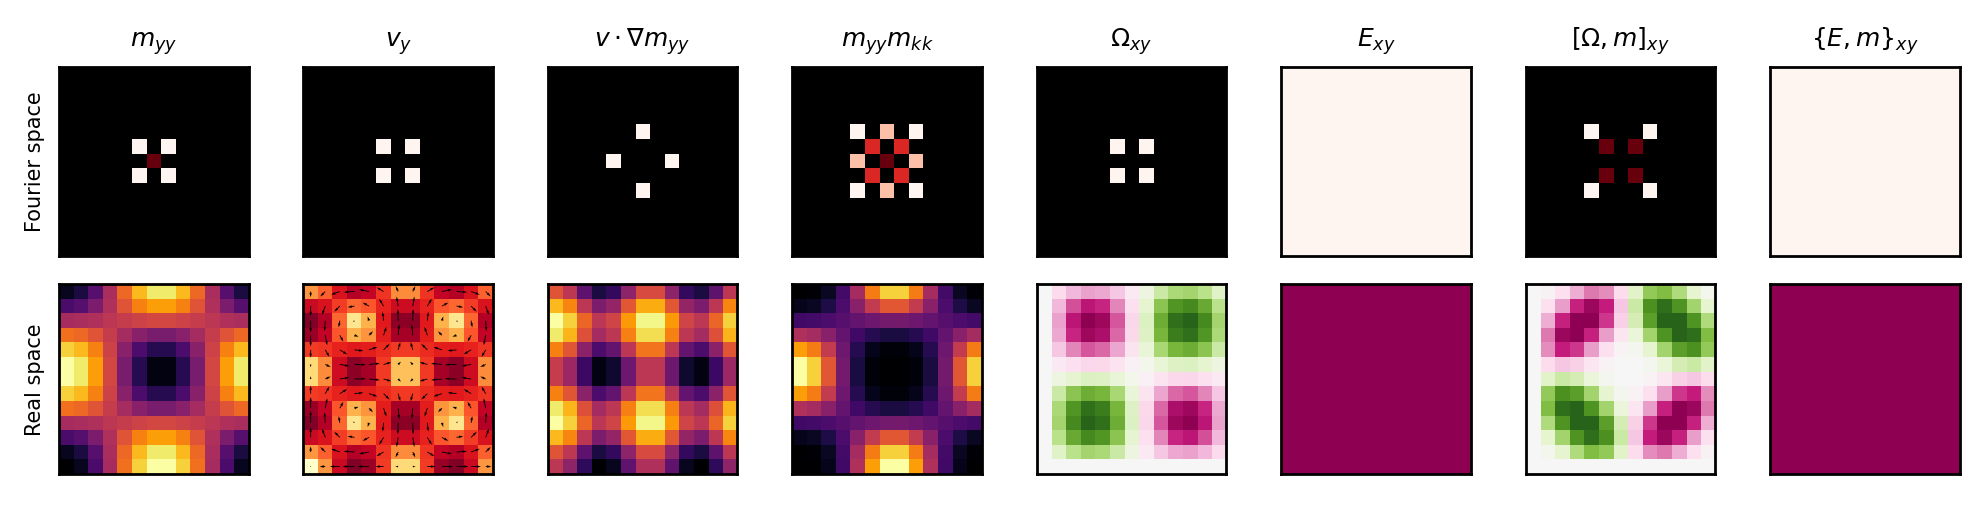

In [105]:
plt.rcParams['image.interpolation'] = None
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['font.size'] = 6

def unshift(f):
    x = np.abs(f)**2
    x /= np.max(x)
    x[x < 1e-3] = 0
    x = np.fft.fftshift(x, axes=(-2, -1))
    x = np.log(x)
    x[np.isnan(x)] = -1e8
    return x


N = 13
qx = np.fft.fftfreq(N, 10)
qy = np.fft.fftfreq(N, 10)
qi = np.stack(np.meshgrid(qx, qy, indexing='ij'))
q = np.linalg.norm(qi, axis=0)

eps = 1e-8
#Define myosin tensor
mq = np.zeros([2, 2, N, N])
mq[0, 0, 1, 1] = -1
mq[0, 0, 1, -1] = -1
mq[0, 0, -1, 1] = -1
mq[0, 0, -1, -1] = -1
mq[0, 0, 0, 0] = 4
#mq[0, 0, N//2, N//2+1] = .0
mq[np.abs(mq) < eps] = 0
mij = np.fft.ifft2(mq).real

vq = -1j * qi * qi[0]**2 / q**4 * mq[0, 0]
vq[0] += 1j * qi[0] / q**2 * mq[0, 0]
vq[:, 0, 0] = 0
print(np.fft.fftshift(mq, axes=(-2, -1))[0, 0, 5:8, 5:8])
print(np.fft.fftshift(vq, axes=(-2, -1))[:, 5:8, 5:8])
vi = np.fft.ifft2(vq).real

grad_mq = 1.0j * qi[:, None, None] * mq[None]
grad_mij = np.fft.ifft2(grad_mq).real
vgrad_mij = np.einsum('kyx,kijyx->ijyx', vi, grad_mij)
vgradmq = np.fft.fft2(vgrad_mij)

m2 = np.einsum('kkyx,ijyx->ijyx', mij, mij)
m2q = np.fft.fft2(m2)

wq = -1j * (qi[1] * vq[0] - qi[0] * vq[1])
wq[np.abs(mq[0, 0]) < eps] = 0
Oxy = np.fft.ifft2(wq).real

eq = -1j * np.einsum('iyx,jyx->ijyx', qi, vq) * 1e5
eq = eq + np.einsum('ijyx->jiyx', eq)
eq[:, :, np.abs(mq[0, 0]) < eps] = 0
Eij = np.fft.ifft2(eq).real

eps_ij = np.array([[0, -1], [1, 0]])
Om = Oxy * (np.einsum('ik,kjyx->ijyx', eps_ij, mij) + np.einsum('ikyx,kj->ijyx', mij, eps_ij))
Omq = np.fft.fft2(Om)

Em = np.einsum('ikyx,kjyx->ijyx', Eij, mij) + np.einsum('ikyx,kjyx->ijyx', mij, Eij)
Emq = np.fft.fft2(Em)

fig, ax = plt.subplots(2, 8, dpi=250, figsize=(8, 2))

kwargs = dict(cmap='Reds', extent=[qx.min(), qx.max(), qy.min(), qy.max()], interpolation='None')
ax[0, 0].imshow(unshift(mq[0, 0]), **kwargs)
ax[1, 0].imshow(mij[0, 0], cmap='inferno')
ax[0, 0].set_title(r'$m_{yy}$')

ax[0, 1].imshow(unshift(vq[0]), **kwargs)
ax[1, 1].quiver(vi[1], vi[0])
ax[1, 1].imshow(np.linalg.norm(vi, axis=0), cmap='YlOrRd')
ax[0, 1].set_title(r'$v_y$')

ax[0, 2].imshow(unshift(vgradmq[0, 0]), **kwargs)
ax[1, 2].imshow(vgrad_mij[0, 0], cmap='inferno')
ax[0, 2].set_title(r'$v \cdot \nabla m_{yy}$')

ax[0, 3].imshow(unshift(m2q[0, 0]), **kwargs)
ax[1, 3].imshow(m2[0, 0], cmap='inferno')
ax[0, 3].set_title(r'$m_{yy} m_{kk}$')

ax[0, 4].imshow(unshift(wq), **kwargs)
ax[1, 4].imshow(Oxy, cmap='PiYG')
ax[0, 4].set_title('$\Omega_{xy}$')

ax[0, 5].imshow(unshift(eq[1, 0]), **kwargs)
ax[1, 5].imshow(Eij[1, 0] * 1e10, cmap='PiYG')
ax[0, 5].set_title('$E_{xy}$')

ax[0, 6].imshow(unshift(Omq[1, 0]), **kwargs)
ax[1, 6].imshow(Om[1, 0] * 1e10, cmap='PiYG')
ax[0, 6].set_title(r'$[\Omega, m]_{xy}$')

ax[0, 7].imshow(unshift(Emq[1, 0]), **kwargs)
ax[1, 7].imshow(Em[1, 0] * 1e10, cmap='PiYG')
ax[0, 7].set_title(r'$\{E, m\}_{xy}$')

for a in ax.flatten(): a.set(xticks=[], yticks=[])
ax[0, 0].set_ylabel('Fourier space')
ax[1, 0].set_ylabel('Real space')
plt.tight_layout()

If we want a stable myosin intensity pattern, we can consider that component of the myosin dynamics equation $\dot{\mathbf{m}} + \mathbf{v} \cdot \nabla m = A (1 - \kappa \, c) \mathbf{m} + B \mathbf{m} \text{Tr}(\mathbf{m}) $. Taking $\dot{m} \rightarrow 0$ and a Fourier transform, we obtain
\begin{equation}
\sum_{q,k} \left[ i \mathbf{q} \cdot \mathbf{v}_{\mathbf{q}} m_{\mathbf{k}} - A (\delta_{qk} - \kappa c_{\mathbf{q}}) m_{\mathbf{k}} - B m_{\mathbf{q}} m_{\mathbf{k}}\right] e^{i (q + k) x} = 0
\end{equation}

Thus, to make a given myosin/flow pattern a fixed point, we simply require that, for all $\mathbf{q}$
\begin{equation}
    c_{\mathbf{q}} = \frac{\left[ m_{\mathbf{q}} - \frac{1}{A} \left( i \mathbf{q} \cdot \mathbf{v}_{\mathbf{q}} - B m_{\mathbf{q}} \right) \sum_k m_{\mathbf{k}} e^{i k x} \right]}{\kappa \sum_k m_{\mathbf{k}} e^{i k x} }
\end{equation}

\begin{equation}
    c_{\mathbf{q}} = - \frac{1}{A\kappa} \left( i \mathbf{q} \cdot \mathbf{v}_{\mathbf{q}} - B m_{\mathbf{q}} \right) + \frac{m_{\mathbf{q}}}{\kappa \sum_k m_{\mathbf{k}} e^{i k x} }
\end{equation}

[[-1.  0. -1.]
 [ 0.  4.  0.]
 [-1.  0. -1.]]
[[-32.5   0.   32.5]
 [  0.    0.    0. ]
 [-32.5   0.   32.5]]
[[  2.022   0.      2.022]
 [  0.    276.189   0.   ]
 [  2.022   0.      2.022]]


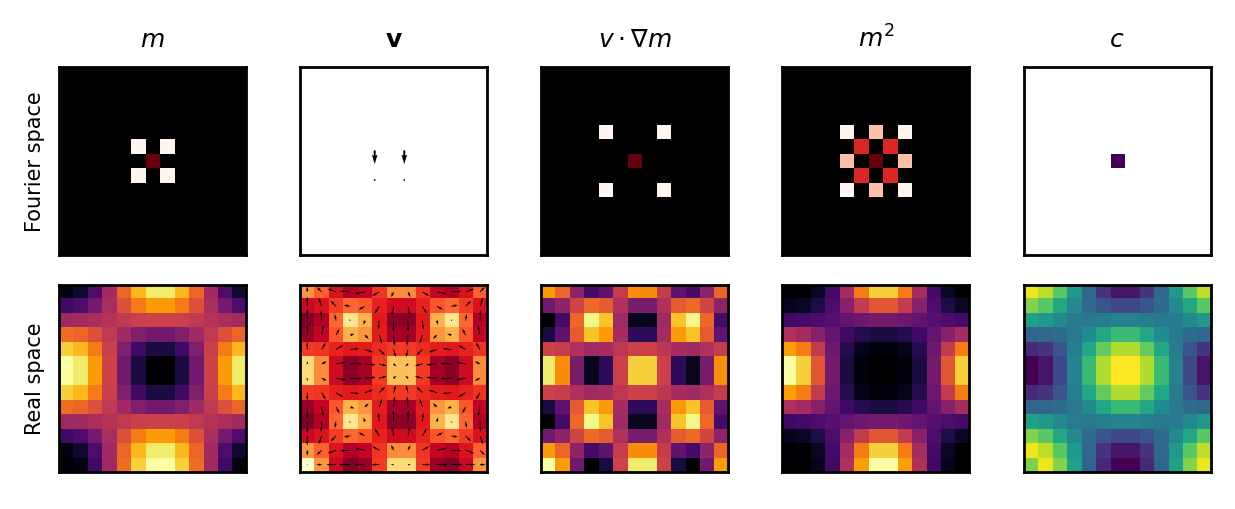

In [106]:
plt.rcParams['image.interpolation'] = None
plt.rcParams['font.size'] = 6

np.set_printoptions(precision=3, suppress=True)

def first_N_harmonics(f, N=1):
    qx = np.fft.fftfreq(f.shape[-1], d=1/f.shape[-1])
    qy = np.fft.fftfreq(f.shape[-2], d=1/f.shape[-2])
    q = np.stack(np.meshgrid(qy, qx, indexing='ij'))
    q = np.linalg.norm(q, axis=0)
    
    x = np.fft.fftshift(f, axes=(-2, -1))
    q = np.fft.fftshift(q, axes=(-2, -1))
    bounds = np.argwhere(q <= N)
    i0 = np.min(bounds[:, 0])
    i1 = np.max(bounds[:, 0])
    j0 = np.min(bounds[:, 1])
    j1 = np.max(bounds[:, 1])
    return x[..., i0:i1+1, j0:j1+1]
    

def unshift(f):
    x = np.abs(f)**2
    x /= np.max(x)
    x[x < 1e-3] = 0
    x = np.fft.fftshift(x, axes=(-2, -1))
    x = np.log(x)
    x[np.isnan(x)] = -1e8
    return x

#Define myosin tensor
mq = np.zeros([N, N])
mq[1, 1] = -1
mq[1, -1] = -1
mq[-1, 1] = -1
mq[-1, -1] = -1
mq[0, 0] = 4
mq[np.abs(mq) < eps] = 0
m = np.fft.ifft2(mq).real
m[m == 0] = np.min(m[m != 0])

vq = -1j * qi * q[0]**2 / q**4 * mq
vq[0] += 1j * q[0] / q**2 * mq
vq[:, 0, 0] = 0
vi = np.fft.ifft2(vq).real

grad_mq = 1.0j * qi * mq[None]
grad_m = np.fft.ifft2(grad_mq).real
vgrad_m = np.einsum('kyx,kyx->yx', vi, grad_m)
vgradmq = np.fft.fft2(vgrad_m)

m2q = np.fft.fft2(m*m)

A, B, k = 1, -1, 0.6
c = (A * m + B * m**2 - vgrad_m) / (k * m)
cq= np.fft.fft2(c)
cq[mq == 0] = 0
print(first_N_harmonics(mq, N=1).real)
print(first_N_harmonics(vq[1], N=1).imag)
print(first_N_harmonics(cq, N=1).real)
fig, ax = plt.subplots(2, 5, dpi=250, figsize=(5, 2))

kwargs = dict(cmap='Reds', extent=[qx.min(), qx.max(), qy.min(), qy.max()], interpolation='None')
ax[0, 0].imshow(unshift(mq), **kwargs)
ax[1, 0].imshow(m, cmap='inferno')
ax[0, 0].set_title(r'$m$')

ax[0, 1].imshow(unshift(vq[0]), **kwargs)
ax[0, 1].quiver(unshift(vq[1]), unshift(vq[0]), scale=3e1, width=0.01)
ax[1, 1].quiver(vi[1], vi[0])
ax[1, 1].imshow(np.linalg.norm(vi, axis=0), cmap='YlOrRd')
ax[0, 1].set_title(r'$\mathbf{v}$')

ax[0, 2].imshow(unshift(vgradmq), **kwargs)
ax[1, 2].imshow(vgrad_m, cmap='inferno')
ax[0, 2].set_title(r'$v \cdot \nabla m$')

ax[0, 3].imshow(unshift(m2q), **kwargs)
ax[1, 3].imshow(m*m, cmap='inferno')
ax[0, 3].set_title(r'$m^2$')

ax[0, 4].imshow(unshift(cq))
ax[1, 4].imshow(c, cmap='viridis')
ax[0, 4].set_title(r'$c$')

for a in ax.flatten(): a.set(xticks=[], yticks=[])
ax[0, 0].set_ylabel('Fourier space')
ax[1, 0].set_ylabel('Real space')
plt.tight_layout()

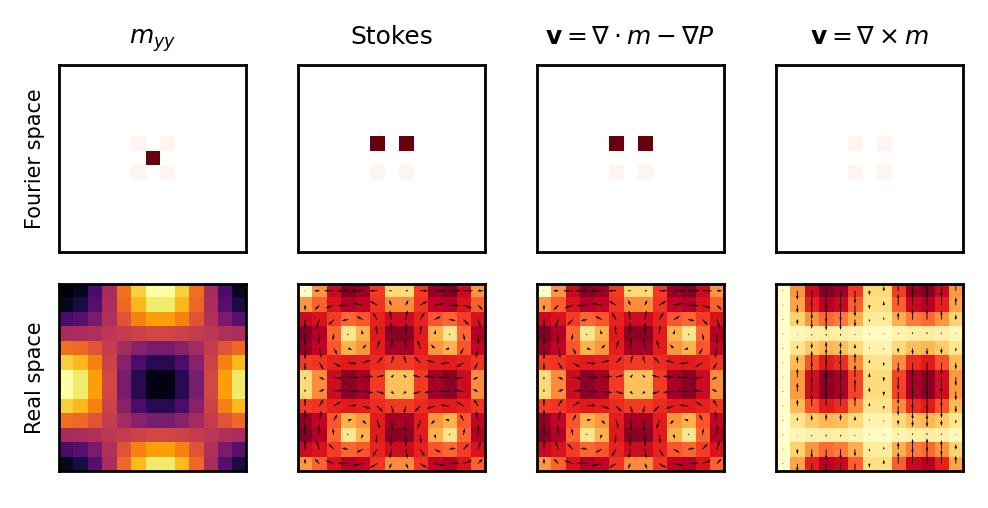

In [4]:
plt.rcParams['image.interpolation'] = None
plt.rcParams['font.size'] = 6

def unshift(f):
    x = np.abs(f)**2
    x /= np.max(x)
    x[x < 1e-3] = 0
    x = np.fft.fftshift(x, axes=(-2, -1))
    x = np.log(x)
    x[np.isnan(x)] = -1e8
    return x


N = 13
qx = np.fft.fftfreq(N, 10)
qy = np.fft.fftfreq(N, 10)
qi = np.stack(np.meshgrid(qx, qy, indexing='ij'))
q = np.linalg.norm(qi, axis=0)

eps = 1e-8
#Define myosin tensor
mq = np.zeros([2, 2, N, N])
mq[0, 0, 1, 1] = -1
mq[0, 0, 1, -1] = -1
mq[0, 0, -1, 1] = -1
mq[0, 0, -1, -1] = -1
mq[0, 0, 0, 0] = 4
#mq[0, 0, N//2, N//2+1] = .0
mq[np.abs(mq) < eps] = 0
mij = np.fft.ifft2(mq).real

fig, ax = plt.subplots(2, 4, dpi=250, figsize=(4, 2))

kwargs = dict(cmap='Reds', extent=[qx.min(), qx.max(), qy.min(), qy.max()], interpolation='None')
ax[0, 0].imshow(unshift(mq[0, 0]), **kwargs)
ax[1, 0].imshow(mij[0, 0], cmap='inferno')
ax[0, 0].set_title(r'$m_{yy}$')

def plot_v(ax, vq, title):
    ax[0].imshow(unshift(vq[0]), **kwargs)
    ax[1].quiver(vi[1], vi[0])
    ax[1].imshow(np.linalg.norm(vi, axis=0), cmap='YlOrRd')
    ax[0].set_title(title)

vq = -1j * qi * q[0]**2 / q**4 * mq[0, 0]
vq[0] += 1j * q[0] / q**2 * mq[0, 0]
vq[:, 0, 0] = 0
vi = np.fft.ifft2(vq).real
plot_v(ax[:, 1], vq, 'Stokes')

vq = -1j * qi * q[0]**2 / q**2 * mq[0, 0]
vq[0] += 1j * q[0] / q**2 * mq[0, 0]
vq[:, 0, 0] = 0
vi = np.fft.ifft2(vq).real
plot_v(ax[:, 2], vq, r'$\mathbf{v} = \nabla \cdot m - \nabla P$')

eps_ij = np.array([[0, -1], [1, 0]])
vq = -1j * np.einsum('jk,jyx,ikyx->iyx', eps_ij, qi, mq)
vq[:, 0, 0] = 0
vi = np.fft.ifft2(vq).real
plot_v(ax[:, 3], vq, r'$\mathbf{v} = \nabla \times m$')

for a in ax.flatten(): a.set(xticks=[], yticks=[])
ax[0, 0].set_ylabel('Fourier space')
ax[1, 0].set_ylabel('Real space')
plt.tight_layout()

# Path towards an "almost" fixed point

In [2]:
plt.rcParams['image.interpolation'] = None
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['font.size'] = 6

np.set_printoptions(precision=3, suppress=True)

def first_N_harmonics(f, N=1):
    qx = np.fft.fftfreq(f.shape[-1], d=1/f.shape[-1])
    qy = np.fft.fftfreq(f.shape[-2], d=1/f.shape[-2])
    q = np.stack(np.meshgrid(qy, qx, indexing='ij'))
    q = np.linalg.norm(q, axis=0)
    
    x = np.fft.fftshift(f, axes=(-2, -1))
    q = np.fft.fftshift(q, axes=(-2, -1))
    bounds = np.argwhere(q <= N)
    i0 = np.min(bounds[:, 0])
    i1 = np.max(bounds[:, 0])
    j0 = np.min(bounds[:, 1])
    j1 = np.max(bounds[:, 1])
    return x[i0:i1+1, j0:j1+1][::-1, :] #Origin lower

def unshift(f, cutoff=1e-3):
    x = np.abs(f)**2
    x[x < cutoff * np.max(f)] = 0
    x = np.fft.fftshift(x, axes=(-2, -1))
    x = np.log(x)
    return x

def plot_tensor(E, Eq, label='E'):
    fig, ax = plt.subplots(2, 3, dpi=250, figsize=(3, 2))
    for a in ax.flatten(): a.set(xticks=[], yticks=[])
    ax[0, 0].set_ylabel('Fourier space')
    ax[1, 0].set_ylabel('Real space')

    plt.tight_layout()
    
    ax[0, 0].imshow(unshift(Eq[1, 1]), **kwargs)
    ax[1, 0].imshow(E[1, 1], cmap='inferno')
    ax[0, 0].set_title(r'$%s_{xx}$' % label)

    ax[0, 1].imshow(unshift(Eq[0, 0]), **kwargs)
    ax[1, 1].imshow(E[0, 0], cmap='inferno')
    ax[0, 1].set_title(r'$%s_{yy}$' % label)

    ax[0, 2].imshow(unshift(Eq[0, 1]), **kwargs)
    ax[1, 2].imshow(E[0, 1], cmap='inferno')
    ax[0, 2].set_title(r'$%s_{xy}$' % label)

## 1. Establish a cadherin pattern with low-order harmonics

Compute the fixed point while neglecting contributions from the convective derivative

$$ \dot{m}_{ij} = A[1 - k c] m_{ij} + B m_{ij} \text{Tr}(m) $$

$$ \text{Tr}(m_0) = -\frac{A}{B} [ 1 - k c] $$

Here, we establish a cadherin pattern with the spectrum 

\begin{equation}
    c(\mathbf{q}) = \begin{cases}
       c_0 ,& \mathbf{q} = 0 \\
       c_1 / 4 ,& \mathbf{q} = (\pm 1, \pm 1) \\
       0 ,& \text{otherwise}
    \end{cases}
\end{equation}

The corresponding fixed point has the spec∂trum
\begin{equation}
    m_{yy}(\mathbf{q}) = \begin{cases}
       -\frac{A}{B} (1 - k\, c_0) ,& \mathbf{q} = 0 \\
       \frac{A k}{4B} c_1 ,& \mathbf{q} = (\pm 1, \pm 1) \\
       0 ,& \text{otherwise}
    \end{cases}
\end{equation}

\begin{equation}
    \mathbf{v}(\mathbf{q}) = \begin{cases}
       \frac{i \alpha A k}{16 \mu B} c_1 \begin{pmatrix} -q_x \\ q_y \end{pmatrix}
           ,& \mathbf{q} = (\pm 1, \pm 1) \\
       0 ,& \text{otherwise}
    \end{cases}
\end{equation}


Cadherin
[[0.1 0.  0.1]
 [0.  1.2 0. ]
 [0.1 0.  0.1]]

Myosin
[[-0.06 -0.   -0.06]
 [-0.    0.28 -0.  ]
 [-0.06 -0.   -0.06]]
m_yy(0, 0) = -A (1 - k c0) / B:	 True
m_yy(±1, ±1) = k A c1 / 4 B:	 True

Velocity
[[-0.045 -0.     0.045]
 [ 0.     0.    -0.   ]
 [-0.045 -0.     0.045]]
[[-0.045  0.    -0.045]
 [ 0.     0.     0.   ]
 [ 0.045  0.     0.045]]
Abs(Vx) = Abs(Vy):	 True
Vx(qx) = -Vx(-qx):	 True
Vy(qy) = -Vy(-qy):	 True
Abs(Vy(±1, ±1)) = (alpha A k c1) / (16 mu B):  True

RHS is zero:  True


Text(0.5, 1.0, '$A[1 - k c] m + B m^2$')

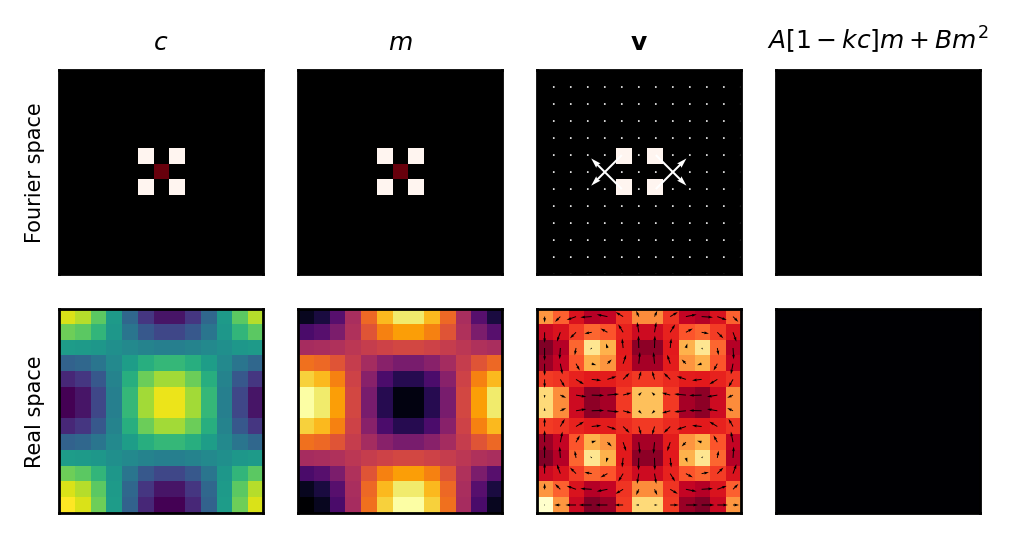

In [3]:
N = 13
half = N//2
qx = np.fft.fftfreq(N, 1/N)
qy = np.fft.fftfreq(N, 1/N)
qi = np.stack(np.meshgrid(qx, qy, indexing='ij'))
q = np.linalg.norm(qi, axis=0)

#Define parameters
alpha = 3
mu = 1
am = alpha / mu
A, B, k = 1, -1, 0.6

kwargs = dict(cmap='Reds', extent=[qx.min(), qx.max(), qy.min(), qy.max()])
plt.cm.Reds.set_bad('black')
fig, ax = plt.subplots(2, 4, dpi=250, figsize=(4, 2))
for a in ax.flatten(): a.set(xticks=[], yticks=[])
ax[0, 0].set_ylabel('Fourier space')
ax[1, 0].set_ylabel('Real space')
plt.tight_layout()

#Define cadherin field
cq = np.zeros([N, N])
c0, c1 = 1.2, 0.4
cq[ 0,  0] = c0
cq[ 1,  1] = c1 / 4
cq[ 1, -1] = c1 / 4
cq[-1,  1] = c1 / 4
cq[-1, -1] = c1 / 4
c = np.fft.ifft2(cq).real * N**2

print('\nCadherin')
print(first_N_harmonics(cq, N=1).real)

ax[0, 0].imshow(unshift(cq), **kwargs)
ax[1, 0].imshow(c, cmap='viridis')
ax[0, 0].set_title(r'$c$')

#Myosin fixed point
mq = A / B * k * cq
mq[0, 0] -= A / B
m = np.fft.ifft2(mq).real * N**2

print('\nMyosin')
print(first_N_harmonics(mq, N=1).real)
print('m_yy(0, 0) = -A (1 - k c0) / B:\t', np.allclose(mq[0, 0], -A/B * (1 - k * c0))) 
print('m_yy(±1, ±1) = k A c1 / 4 B:\t', np.allclose(mq[1, 1], k * A * c1 / (4 * B)))

ax[0, 1].imshow(unshift(mq), **kwargs)
ax[1, 1].imshow(m, cmap='inferno')
ax[0, 1].set_title(r'$m$')

#Compute corresponding flow
vq     = -qi * qi[0]**2 / q**4
vq[0] += qi[0] / q**2
vq    = 1j * am * mq * vq.astype(np.complex128)
vq[:, 0, 0] = 0
vi = np.fft.ifft2(vq).real * N**2

print('\nVelocity')
print(first_N_harmonics(vq[1], N=1).imag)
print(first_N_harmonics(vq[0], N=1).imag)
print('Abs(Vx) = Abs(Vy):\t', np.allclose(np.abs(vq[0]), np.abs(vq[1])))
print('Vx(qx) = -Vx(-qx):\t', np.allclose(vq[1, :, 1:], -vq[1, :, 1:][:, ::-1]))
print('Vy(qy) = -Vy(-qy):\t', np.allclose(vq[0, 1:], -vq[0, 1:][::-1]))
print('Abs(Vy(±1, ±1)) = (alpha A k c1) / (16 mu B): ', np.allclose(vq[0, 1, 1].imag, am * A * k * c1 / (16 * B))) 

ax[0, 2].imshow(unshift(vq[0]), **kwargs)
ax[0, 2].quiver(qi[1], qi[0], vq[1].imag, vq[0].imag, 
                color='white', scale=3e-1, width=0.01)
ax[1, 2].quiver(vi[1], vi[0])
ax[1, 2].imshow(np.linalg.norm(vi, axis=0), cmap='YlOrRd')
ax[0, 2].set_title(r'$\mathbf{v}$')

# Show RHS is zero
rhs = A * (1 - k * c) * m + B * m**2
rhsq = np.fft.fft2(rhs)

print('\nRHS is zero: ', np.allclose(rhsq, 0))
ax[0, 3].imshow(unshift(rhsq), **kwargs)
ax[1, 3].imshow(rhs, cmap='inferno', vmin=0, vmax=np.max(m))
ax[0, 3].set_title(r'$A[1 - k c] m + B m^2$')

## 2. Re-establish convective derivative and observe leading-order harmonic behavior

The convective derivative $\mathbf{v} \cdot \nabla m$ only has a $yy$ component - it corresponds to the advection of myosin density through the tissue. Its spectrum is
\begin{equation}
    \mathbf{v} \cdot \nabla m_{yy} (\mathbf{q}) = \begin{cases}
        -\frac{\alpha}{\mu} \left(\frac{k A}{8 B}\right)^2
        q^2 c_1^2 ,&\mathbf{q} = (0, \pm 2) \\
        \frac{\alpha}{\mu} \left(\frac{k A}{8 B}\right)^2
        q^2 c_1^2 ,&\mathbf{q} = (\pm 2, 0) \\
        0 ,& \text{otherwise}
    \end{cases}
\end{equation}

The co-rotation term $[\Omega, m]_{ij} = \Omega_{ik} m_{kj} - m_{ik} \Omega_{kj}$ is symmetric and has no diagonal component - co-rotation only re-orients the vector field rather than increasing density (trace). The spectrum of the vorticity is
\begin{equation}
    \Omega(\mathbf{q}) = \begin{cases}
        -\frac{\alpha k A}{16 \mu B} c_1 q_x q_y ,&\mathbf{q} = (\pm 1, \pm 1) \\
        0 ,& \text{otherwise}
    \end{cases}
\end{equation}

which leads to the following spectrum for $[\Omega, m]$
\begin{equation}
    [\Omega, m]_{xy} (\mathbf{q}) = \begin{cases}
        \frac{\alpha}{\mu} \frac{k A^2}{8 B^2} \frac{q_x q_y}{q^2} (1 - k c_0)  c_1 
         ,&\mathbf{q} = (\pm 1, \pm 1) \\
        \frac{\alpha}{\mu} \left(\frac{k A}{8 B}\right)^2
        \frac{q_x q_y}{q^2} c_1^2 ,&\mathbf{q} = (\pm 2, \pm 2) \\
        0 ,& \text{otherwise}
    \end{cases}
\end{equation}

Note that each of the above nonlinearities introduces contributions at higher wavenumbers. However, only the co-rotation term induces an effect at the leading-order harmonics

Convective term
[[ 0.    -0.    -0.011 -0.     0.   ]
 [ 0.    -0.     0.    -0.     0.   ]
 [ 0.011 -0.    -0.    -0.     0.011]
 [ 0.    -0.     0.    -0.     0.   ]
 [ 0.    -0.    -0.011 -0.     0.   ]]
v.grad(m)(2, 0) = alpha / mu (k A c1 / 8 B)^2 q^2:  True

Co-rotation term
[[ 0.003  0.     0.    -0.    -0.003]
 [ 0.    -0.013  0.     0.013 -0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [-0.     0.013  0.    -0.013  0.   ]
 [-0.003 -0.     0.     0.     0.003]]
Co-rotation is symmetric:	 True
Co-rotation has no diagonal:	 True
|[O, m](±1, ±1)| = (A/B)^2 (alpha k c1) / (16 mu) (1 - k c0) True
|[O, m](±2, ±2)| = -alpha / mu (k A c1 / 8 B)^2 True


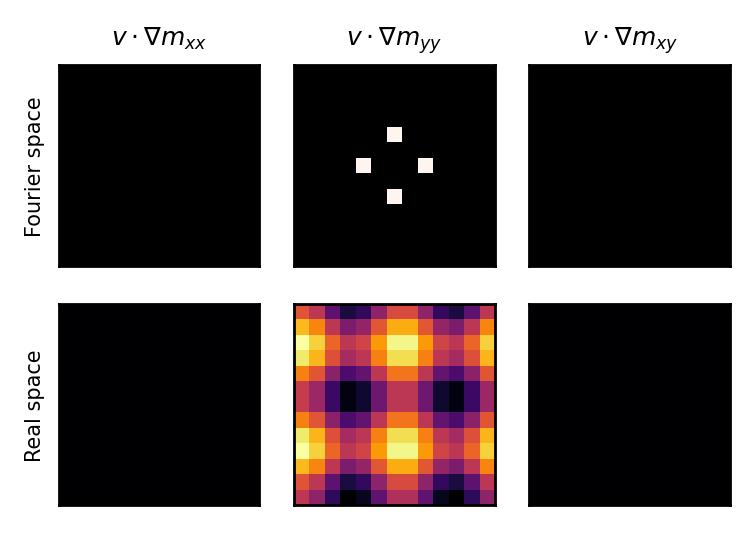

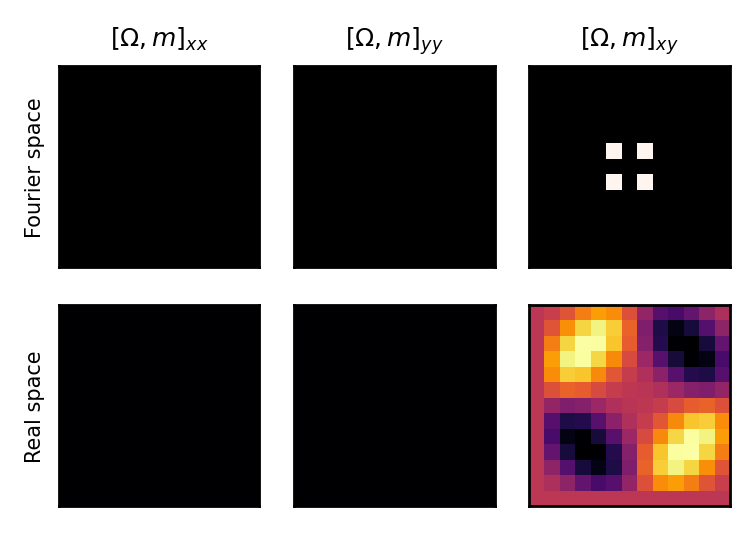

In [4]:
mij  = np.array([[1,  0], [0, 0]])[..., None, None] * m
mijq = np.array([[1,  0], [0, 0]])[..., None, None] * mq

print('Convective term')

gradmq = 1.0j * qi[:, None, None] * mijq[None]
gradm = np.fft.ifft2(gradmq).real
#print(first_N_harmonics(gradmq[0, 0, 0], N=1).imag)

#gradm = np.stack([
#    np.gradient(np.pad(mij,((0, 0), (0, 0), (2, 2), (0, 0)), mode='wrap'), 1/N, axis=-2, edge_order=1)[..., 2:-2, :],
#    np.gradient(np.pad(mij,((0, 0), (0, 0), (0, 0), (2, 2)), mode='wrap'), 1/N, axis=-1, edge_order=1)[..., :, 2:-2],
#])
#gradmq = np.fft.fft2(gradm) / N**2
#print(first_N_harmonics(gradmq[0, 0, 0], N=1).imag)

vgradm = np.einsum('kyx,kijyx->ijyx', vi, gradm)
vgradmq = np.fft.fft2(vgradm)

print(first_N_harmonics(vgradmq[0, 0], N=2).real)
print('v.grad(m)(2, 0) = alpha / mu (k A c1 / 8 B)^2 q^2: ', np.allclose(vgradmq[0, 0, 0, 2].real,
                                                                         am * (k * A * c1 / 8 / B)**2 * 4))

plot_tensor(vgradm, vgradmq, 'v \\cdot \\nabla m')

wq = 1j * (qi[1] * vq[0] - qi[0] * vq[1]) / 2.
w = np.fft.ifft2(wq).real * N**2

wij = np.array([[0, -1], [1, 0]])[..., None, None] * w
Om = np.einsum('ikyx,kjyx->ijyx', wij, mij) - np.einsum('ikyx,kjyx->ijyx', mij, wij)
Omq = np.fft.fft2(Om) / N**2

print('\nCo-rotation term')
print(first_N_harmonics(Omq[1, 0], N=2).real)

print('Co-rotation is symmetric:\t', np.allclose(Omq, Omq[::-1, ::-1]))
print('Co-rotation has no diagonal:\t', np.logical_and(np.allclose(Omq[0, 0], 0), np.allclose(Omq[1, 1], 0)))

print('|[O, m](±1, ±1)| = (A/B)^2 (alpha k c1) / (16 mu) (1 - k c0)', np.allclose(Omq[1, 0, 1, 1].real, 
                                                                                  A**2 / B**2 * am * k * c1 / 16 * (1 - k * c0)))
print('|[O, m](±2, ±2)| = -alpha / mu (k A c1 / 8 B)^2', np.allclose(Omq[1, 0, 2, 2].real,
                                                                     -am * (k * A * c1 / 8 / B)**2))

plot_tensor(Om, Omq, '[\\Omega, m]')

## 3. Eliminate leading-order effects of convective derivative

The co-rotation term destroys orientational order by introducing a $\mathbf{q} = (\pm 1, \pm 1)$ off-diagonal component to the left-hand side. 


Strain-recruitment term
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


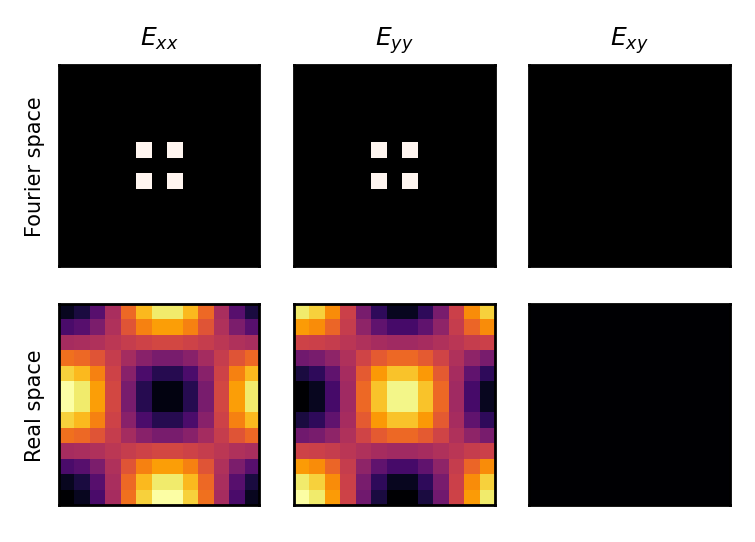

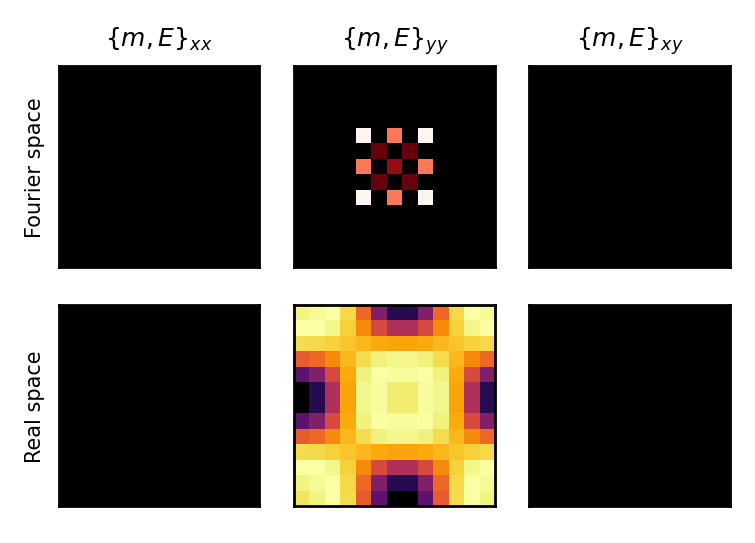

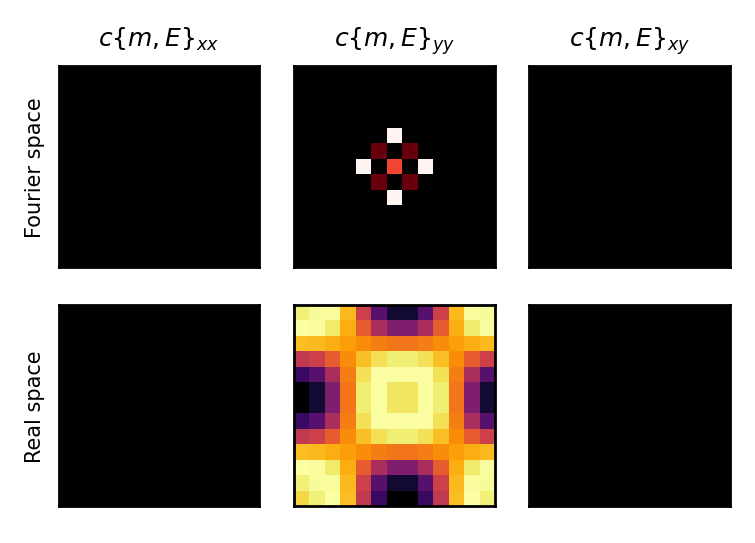

In [5]:
Eijq = np.einsum('iyx,jyx->ijyx', qi, vq)
Eijq = 1j / 2. * (Eijq + np.einsum('ijyx->jiyx', Eijq))
Eij = np.fft.ifft2(Eijq).real * N**2

plot_tensor(Eij, Eijq, 'E')

Em = np.einsum('ikyx,kjyx->ijyx', Eij, mij) + np.einsum('ikyx,kjyx->ijyx', mij, Eij)
Emq = np.fft.fft2(Em) / N**2

plot_tensor(Em, Emq, '\\{ m, E\\}')

cEm = c * Em
cEmq = np.fft.fft2(cEm) / N**2
plot_tensor(cEm, cEmq, 'c \\{ m, E\\}')

print('\nStrain-recruitment term')
print(first_N_harmonics(cEmq[0, 1], N=2).real)

Convective derivative
[[ 0.    -0.    -0.011 -0.     0.   ]
 [ 0.    -0.     0.    -0.     0.   ]
 [ 0.011 -0.    -0.    -0.     0.011]
 [ 0.    -0.     0.    -0.     0.   ]
 [ 0.    -0.    -0.011 -0.     0.   ]]

Strain-recruitment term
[[-0.003  0.    -0.006  0.    -0.003]
 [ 0.     0.01   0.     0.01   0.   ]
 [-0.006 -0.    -0.012 -0.    -0.006]
 [ 0.     0.01   0.     0.01   0.   ]
 [-0.003  0.    -0.006  0.    -0.003]]

Strain-recruitment term
[[-0.005  0.    -0.011  0.    -0.005]
 [ 0.     0.025  0.     0.025  0.   ]
 [-0.011 -0.    -0.022 -0.    -0.011]
 [ 0.     0.025  0.     0.025  0.   ]
 [-0.005  0.    -0.011  0.    -0.005]]

Strain-recruitment term
[[-0.008  0.    -0.016  0.    -0.008]
 [ 0.     0.04  -0.     0.04   0.   ]
 [-0.016  0.    -0.031  0.    -0.016]
 [ 0.     0.04  -0.     0.04   0.   ]
 [-0.008  0.    -0.016  0.    -0.008]]


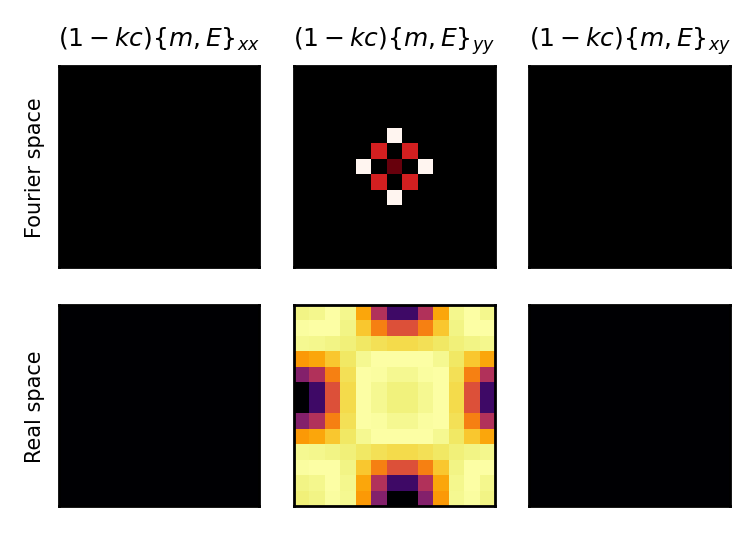

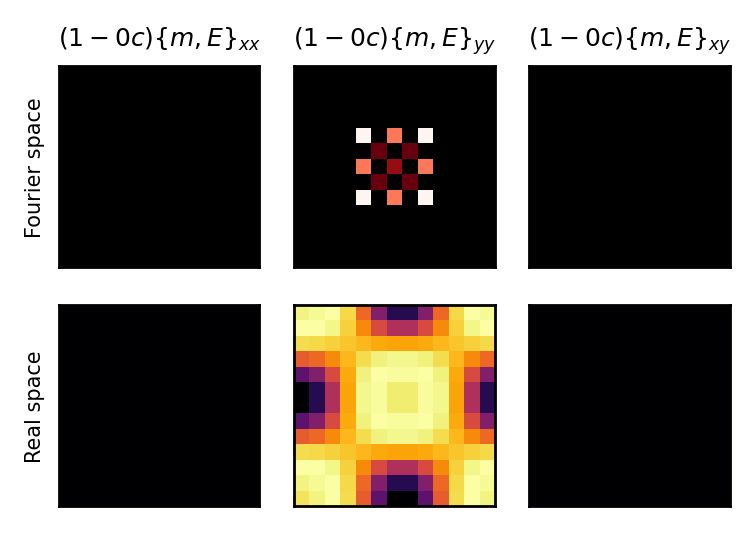

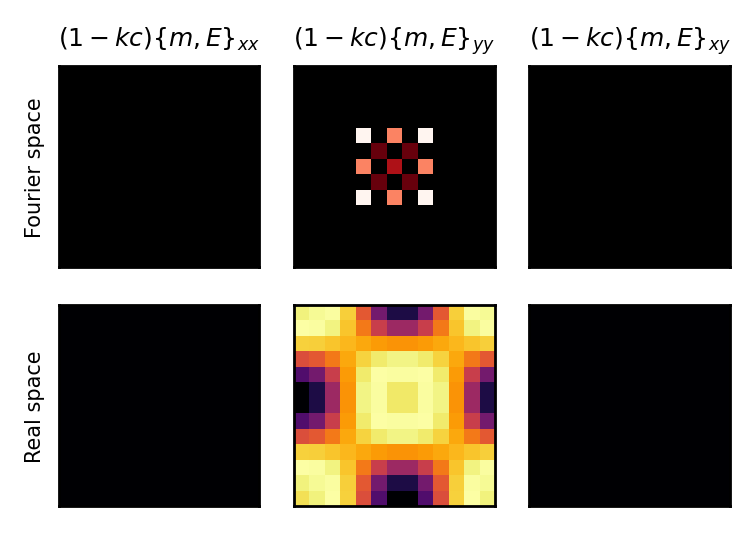

In [6]:
print('Convective derivative')
print(first_N_harmonics(vgradmq[0, 0], N=2).real)

cEm = (1 - k * c) * Em
cEmq = np.fft.fft2(cEm) / N**2
plot_tensor(cEm, cEmq, '(1 - k c) \\{ m, E\\}')

print('\nStrain-recruitment term')
print(first_N_harmonics(cEmq[0, 0], N=2).real)


cEm = Em
cEmq = np.fft.fft2(cEm) / N**2
plot_tensor(cEm, cEmq, '(1 - 0 c) \\{ m, E\\}')

print('\nStrain-recruitment term')
print(first_N_harmonics(cEmq[0, 0], N=2).real)


cEm = (1 + k * c) * Em
cEmq = np.fft.fft2(cEm) / N**2
plot_tensor(cEm, cEmq, '(1 - k c) \\{ m, E\\}')

print('\nStrain-recruitment term')
print(first_N_harmonics(cEmq[0, 0], N=2).real)